# **Step 1: Import Library**

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# **Step 2: Load Dataset**

In [4]:
df = pd.read_csv("../data/Books_rating.csv.zip", compression="zip")

df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [5]:
df.info()

print(df.isnull().sum())

print(f"Number of unique users: {df["User_id"].nunique()}")
print(f"Number of unique books: {df["Id"].nunique()}")
print(f"Number of unique ratings: {df["review/score"].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB
Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64
Number of unique users: 1008972
Number of unique books: 221998
Number of unique ratings: 5


# **Step 3: Data Preprocessing**

## ***Filtering***

In [6]:
df_filter = df[["Id", "User_id", "review/score"]].dropna()

df_filter.rename(columns={"User_id": "UserID", "Id": "BookID", "review/score": "Rating"}, inplace=True)

df_filter.head()

,BookID,UserID,Rating
0,1882931173,AVCGYZL8FQQTD,4.0
1,0826414346,A30TK6U7DNS82R,5.0
2,0826414346,A3UH4UZ4RSVO82,5.0
3,0826414346,A2MVUWT453QH61,4.0
4,0826414346,A22X4XUPKF66MR,4.0


In [7]:
df_filter.info()

print(df_filter.isnull().sum())

print(df_filter.describe())

print(f"Number of unique users: {df_filter["UserID"].nunique()}")
print(f"Number of unique books: {df_filter["BookID"].nunique()}")
print(f"Number of unique ratings: {df_filter["Rating"].nunique()}")

<class 'pandas.core.frame.DataFrame'>
Index: 2438213 entries, 0 to 2999998
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   BookID  object 
 1   UserID  object 
 2   Rating  float64
dtypes: float64(1), object(2)
memory usage: 74.4+ MB
BookID    0
UserID    0
Rating    0
dtype: int64
             Rating
count  2.438213e+06
mean   4.228312e+00
std    1.178634e+00
min    1.000000e+00
25%    4.000000e+00
50%    5.000000e+00
75%    5.000000e+00
max    5.000000e+00
Number of unique users: 1008972
Number of unique books: 216023
Number of unique ratings: 5


In [8]:
user_count = df_filter["UserID"].value_counts(ascending=True, normalize=True)
book_count = df_filter["BookID"].value_counts(ascending=True, normalize=True)
rating_count = df_filter["Rating"].value_counts(ascending=True, normalize=True)

print(user_count * 100)
print(book_count* 100)
print(rating_count * 100)

UserID
A3V4NY81KXZAUL    0.000041
AYK8LH8DSCAP0     0.000041
A2ABV8FXF88O9P    0.000041
A1EONVY639PQDY    0.000041
A2XXVRH6VJ8S7Q    0.000041
                    ...   
A1X8VZWTOG8IS6    0.073989
AHD101501WCN1     0.081822
A1D2C0WDCSHUWZ    0.129029
AFVQZQ8PW0L       0.147895
A14OJS0VWMOSWO    0.237674
Name: proportion, Length: 1008972, dtype: float64
BookID
B000HQRTWY    0.000041
0892365161    0.000041
B000F3S7SE    0.000041
1843532336    0.000041
0865970505    0.000041
                ...   
B000NDSX6C    0.150397
B000GQG5MA    0.150438
B000GQG7D2    0.150479
B000ILIJE0    0.151012
B000IEZE3G    0.153719
Name: proportion, Length: 216023, dtype: float64
Rating
2.0     4.906626
1.0     6.199540
3.0     8.732461
4.0    20.185849
5.0    59.975523
Name: proportion, dtype: float64


## ***Normalizing***

In [9]:
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

df_filter["UserID"] = user_encoder.fit_transform(df_filter["UserID"])
df_filter["BookID"] = book_encoder.fit_transform(df_filter["BookID"])

df_filter.head()

,BookID,UserID,Rating
0,127556,974366,4.0
1,72373,538933,5.0
2,72373,758571,5.0
3,72373,436243,4.0
4,72373,288505,4.0


In [10]:
probabilities = {
    1: 0.78,
    2: 1.0,
    3: 0.60,
    4: 0.24,
    5: 0.08
}

df_filter["keep"] = df_filter["Rating"].apply(lambda x: np.random.rand() < probabilities[x])

df_balanced = df_filter[df_filter["keep"]].drop(columns=["keep"])

print(df_balanced["Rating"].value_counts(normalize=True))

Rating
3.0    0.212663
2.0    0.199296
4.0    0.196348
1.0    0.196266
5.0    0.195426
Name: proportion, dtype: float64


## ***Visualizing***

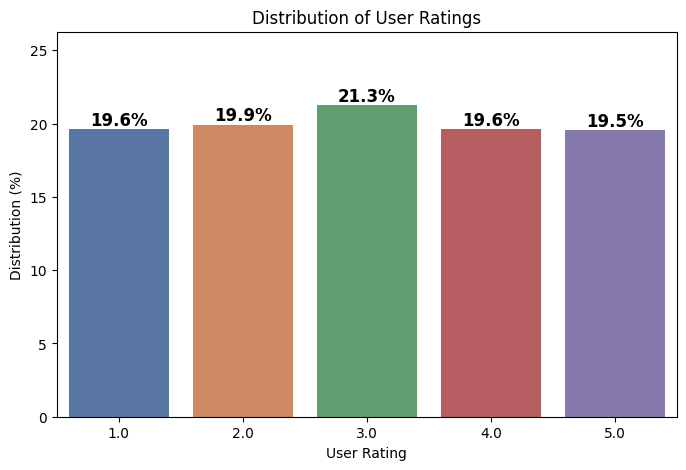

In [11]:
rating_counts = df_balanced["Rating"].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, hue=rating_counts.index, palette="deep", legend=False)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.xlabel("User Rating")
plt.ylabel("Distribution (%)")
plt.title("Distribution of User Ratings")
plt.ylim(0, max(rating_counts.values) + 5)

plt.savefig("../images/user_rating_distribution.png", dpi=300, facecolor="white", bbox_inches="tight", transparent=True)

plt.show()